<a href="https://colab.research.google.com/github/TehLedRed/SpringerManuscript/blob/main/Simulation/NegativeBinomial/phi_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import keras
from scipy import optimize
from scipy.stats import expon
import os.path
import matplotlib.pyplot as plt
!pip install ipython-autotime
%load_ext autotime
!pip install import-ipynb
import import_ipynb
from google.colab import output
output.clear()

time: 4.18 s (started: 2023-10-06 14:19:10 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 33.4 s (started: 2023-10-06 14:20:36 +00:00)


In [ ]:
%cd /content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
import generateData
import nbCure

/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
importing Jupyter notebook from generateData.ipynb
importing Jupyter notebook from nbCure.ipynb
time: 3.99 s (started: 2023-10-06 14:21:39 +00:00)


# Load data and preprocessing

In [ ]:
# read fashion_mnist data
(train_img0, train_labels0), (test_img0, test_labels0) = keras.datasets.fashion_mnist.load_data()
# Normalize pixel values
train_img0, test_img0 = train_img0 / 255.0, test_img0 / 255.0

4422102/4422102 [==============================] - 1s 0us/step
time: 5.2 s (started: 2023-10-06 14:21:43 +00:00)


In [ ]:
train_img0 = train_img0.reshape((train_img0.shape[0], 28, 28, 1))
test_img0 = test_img0.reshape((test_img0.shape[0], 28, 28, 1))

time: 525 µs (started: 2023-10-06 14:21:49 +00:00)


# Neural network


In [ ]:
class Model1(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=4,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu,
            dtype=tf.float32
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=12,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu,
            dtype=tf.float32
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv3 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu,
            dtype=tf.float32
        )
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(-1,))
        self.dense2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh, dtype=tf.float32)
        self.dense3 = tf.keras.layers.Dense(dtype=tf.float32, units=1, activation=None, use_bias=False)


    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x_img = self.dense2(x)

        out = self.dense3(x_img)
        return out


time: 45 ms (started: 2023-10-06 14:21:49 +00:00)


# Data generation $M \sim \text{Negative binomial} (\theta, \phi)$

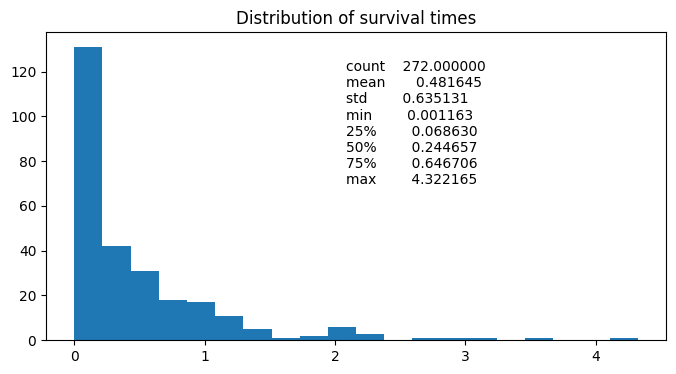

0.456
0.506
time: 202 ms (started: 2023-10-05 01:44:32 +00:00)


In [ ]:
# Pre run
phi = 2
train_data = generateData.simulateData(labels = train_labels0,
                        sampleIndex = generateData.samplingImg(labels = train_labels0, n = 500, p1 = 0.1),
                        phi = phi,
                        c_low = 0.01,
                        theta = [1, 2, 2.5,3, 3.5])

print(np.mean(train_data.m.values == 0))
print(np.mean(train_data.delta.values == 0))

In [ ]:
phi = 2
nTrain = 500
nTest = nTrain*0.25
path = "phi" + str(phi) + "/n" + str(nTrain) + "/"
path

'phi2/n500/'

time: 2.42 ms (started: 2023-10-05 01:44:37 +00:00)


In [ ]:
p_rate = []
c_rate = []
theta = [1, 2, 2.5,3, 3.5]
for sample in range(1,101):

  train_data = generateData.simulateData(labels = train_labels0,
                          sampleIndex = generateData.samplingImg(labels = train_labels0, n = nTrain, p1 = 0.1),
                          phi =phi,
                          c_low = 0.01,
                          theta = theta)

  test_data = generateData.simulateData(labels = test_labels0,
                           sampleIndex = generateData.samplingImg(labels = test_labels0, n = nTest, p1 = 0.1),
                           phi = phi,
                           c_low = 0.01,
                           theta = theta)

  print(np.mean(train_data.m.values == 0))
  print(np.mean(train_data.delta.values == 0))

  p_rate.append(np.mean(train_data.m.values == 0))
  c_rate.append(np.mean(train_data.delta.values == 0))

  train_data.to_csv(path + str(sample) + "_TrainData" + '.csv', index=False)
  test_data.to_csv(path + str(sample) + "_TestData" + '.csv', index=False)

pd.DataFrame({"Cura rate": p_rate, "Overall censoring rate": c_rate}).agg("mean")

# Simulation

In [ ]:
# @title Run nb data setting $\phi$ and sample size
phi = 2 # @param {type:"number"}
nTrain = 500 # @param {type:"number"}

data_path = save_path = "phi" + str(phi) + "/n" + str(nTrain) + "/"
print(data_path)
print(save_path)

phi2/n500/
phi2/n500/
time: 936 µs (started: 2023-10-05 03:11:17 +00:00)


In [ ]:
# @title Run poisson data
nTrain = 500 # @param {type:"number"}
phi = 0.1
data_path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n" + str(nTrain) + "/"
print(data_path)
save_path = "poisson_n" + str(nTrain) + "/"
print(save_path)

/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n500/
poisson_n500/
time: 1.16 ms (started: 2023-10-06 14:21:53 +00:00)


In [ ]:
params = []
for sample in range(1,101):

  train_data = pd.read_csv(data_path + str(sample) + "_TrainData" + '.csv')
  test_data = pd.read_csv(data_path + str(sample) + "_TestData" + '.csv')

  i_train = train_data["index"].values
  i_test = test_data["index"].values

  train_img = train_img0[i_train]
  test_img = test_img0[i_test]

  matNumTrain, matDenomTrain = nbCure.calc_mat(train_data)
  matNumTest, matDenomTest = nbCure.calc_mat(test_data)
  deltaTrain = tf.convert_to_tensor(train_data['delta'].values.reshape(-1, 1), dtype=tf.float32)
  deltaTest = tf.convert_to_tensor(test_data['delta'].values.reshape(-1, 1), dtype=tf.float32)

  model = Model1()
  optimizer = tf.optimizers.Adam(learning_rate=0.0001)
  # first training
  mi = deltaTrain + 1e-2

  alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
  alpha_record = alpha.numpy().copy()

  S1 = nbCure.calc_S1(alpha, matDenomTrain)

  with tf.GradientTape(persistent=True) as tape:
      loss = nbCure.calcNBL1(mi, phi, model(train_img))
      print("iter %d: loss %f" % (1, loss.numpy()))

  grads = tape.gradient(loss, sources = model.variables)
  optimizer.apply_gradients(zip(grads, model.variables))

  var_list = []
  for l in range(len(model.variables)):
      var_list.append(tf.squeeze(model.variables[l]).numpy())
  var_record = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()  # record

  #  second training ---------------------------------------------------
  eps = 100
  num_iter = 1
  best_variable = model.variables

  while eps > 1e-6 and num_iter <= 30:
      minimal = 100.
      early_stopping_at = -1
      count_patience = 0
      patience = 5

      # 1. first updating mi
      mi = nbCure.calcM(deltaTrain, phi, tf.math.exp(model(train_img)), S1)

      # 2. updating alpha, S1
      alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
      S1 = nbCure.calc_S1(alpha, matDenomTrain)

      # calculations for test set
      S1_t = nbCure.calc_S1(alpha, matDenomTest)
      mi_t = nbCure.calcM(deltaTest, phi, tf.math.exp(model(test_img)), S1_t)

      for epoch in range(500):
          # 3. updating network parameters
          with tf.GradientTape() as tape:
              loss = nbCure.calcNBL1(mi, phi, model(train_img))
              loss_t = nbCure.calcNBL1(mi_t, phi, model(test_img))

          if epoch % 250 == 0:
              print("# %d: loss %4f, loss_t %4f" % (num_iter, loss.numpy(), loss_t.numpy()))

          grads = tape.gradient(loss, sources = model.variables)
          optimizer.apply_gradients(zip(grads, model.variables))

          # early stopping ------------------------------
          if loss_t < minimal:
              minimal = loss_t.numpy().copy()
              early_stopping_at = epoch
              best_variable = model.variables
              count_patience = 0

          else:
              count_patience += 1

          if count_patience > patience:
              print("break, converged")
              for i in range(len(model.variables)):
                  model.variables[i].assign(best_variable[i])
              break


      var_list = []
      for l in range(len(model.variables)):
          var_list.append(tf.squeeze(model.variables[l]).numpy())
      var_new = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()

      eps = np.mean((var_new - var_record)**2) + np.mean((alpha-alpha_record)**2)
      var_record = var_new.copy()
      alpha_record = alpha.numpy().copy()

      print("# %d ε: %6f, early stops @E%d" % (num_iter, eps, early_stopping_at))

      # iteration+1
      num_iter += 1

  # update all parameters
  S1 = nbCure.calc_S1(alpha, matDenomTrain)
  mi = nbCure.calcM(deltaTrain, phi, tf.math.exp(model(train_img)), S1)
  alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)

  eta = model(train_img).numpy()
  train_res = pd.DataFrame(np.concatenate([eta, mi.numpy(), S1.numpy()], axis=1), columns=['eta', 'mi','S1'])

  S1_t = nbCure.calc_S1(alpha, matDenomTest)
  mi_t = nbCure.calcM(deltaTest, phi, tf.math.exp(model(test_img)), S1_t)
  eta_t = model(test_img).numpy()
  test_res = pd.DataFrame(np.concatenate([eta_t, mi_t.numpy(), S1_t.numpy()], axis=1), columns=['eta', 'mi', 'S1'])

  train_res.to_csv(save_path + str(sample) + '_TrainRes.csv', index=False)
  test_res.to_csv(save_path + str(sample) + '_TestRes.csv', index=False)

  params.append(tf.squeeze(alpha).numpy())
  del model


Streaming output truncated to the last 5000 lines.
# 2 ε: 0.118776, early stops @E23
# 3: loss 0.884004, loss_t 0.900022
break, converged
# 3 ε: 0.042334, early stops @E16
# 4: loss 0.706848, loss_t 0.744291
break, converged
# 4 ε: 0.018603, early stops @E12
# 5: loss 0.535890, loss_t 0.602845
break, converged
# 5 ε: 0.009463, early stops @E10
# 6: loss 0.381429, loss_t 0.489077
break, converged
# 6 ε: 0.005041, early stops @E8
# 7: loss 0.234312, loss_t 0.388926
break, converged
# 7 ε: 0.003009, early stops @E0
# 8: loss 0.115676, loss_t 0.306154
break, converged
# 8 ε: 0.001762, early stops @E2
# 9: loss -0.024583, loss_t 0.210049
break, converged
# 9 ε: 0.001433, early stops @E0
# 10: loss -0.127183, loss_t 0.153476
break, converged
# 10 ε: 0.000824, early stops @E0
# 11: loss -0.250185, loss_t 0.078837
break, converged
# 11 ε: 0.000716, early stops @E0
# 12: loss -0.346757, loss_t 0.038154
break, converged
# 12 ε: 0.000434, early stops @E0
# 13: loss -0.448381, loss_t -0.003466
bre

## Estimated alphas

In [ ]:
params=pd.DataFrame(params, columns=["1", "2", "3", "4", "5"]); params

,1,2,3,4,5
0,0.570191,0.706890,0.846229,1.199839,1.223061
1,0.721153,0.793001,0.856283,1.132665,1.169990
2,0.674368,0.874675,0.700997,0.597928,0.817711
3,0.758563,0.850729,1.089377,1.059459,1.293321
4,0.471206,0.859114,1.067053,0.993913,0.791593
...,...,...,...,...,...
95,0.873542,1.021483,1.335068,1.008307,1.197159
96,0.596832,0.522007,0.670961,0.771101,0.762105
97,0.469367,0.817678,0.927869,0.913580,0.953530
98,1.128442,1.263830,1.071005,0.923507,1.284041


time: 12.7 ms (started: 2023-10-05 03:32:52 +00:00)


In [ ]:
params.to_csv(save_path + 'params_n' + str(nTrain) + '.csv', index=False)

time: 8.77 ms (started: 2023-10-05 03:32:56 +00:00)


In [ ]:
tf.reduce_sum(matNumTrain, axis = 0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 572.,  607.,  652.,  674., 2495.], dtype=float32)>

time: 4.65 ms (started: 2023-09-08 14:13:51 +00:00)


In [ ]:
temp = matNumTrain*deltaTrain
tf.reduce_sum(temp, axis = 0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([546., 545., 546., 545., 546.], dtype=float32)>

time: 5.27 ms (started: 2023-09-08 14:13:52 +00:00)
